# Lection 1

This follows the lection available here: https://www.youtube.com/watch?v=8SF_h3xF3cE.

## Basics

### [Artificial] Neural Networks (ANN)

A computer system that is modeled to mimic the workings of the human brain.

It is basically a large net of interconnected nodes, each called **neuron**, which are organized in **layers**, each responsible for processing and handling an aspect of the data.

The first layer receives the raw data (eg, image, audio, text) and passes it along to the following layers, until the last one is able to yield the output, that is, a classification, a prediction, etc.

They can be of multiple types – including feedforward neural networks, convolutional neural networks (CNNs), recurrent neural networks (RNNs) – each aiming at handling a specific data type or task.


### Deep Learning

It is a subfield of machine learning that uses ANNs to solve complex problems. The _**deep**_ refers to the depth (ie number of layers) of the neural network. This can range anywhere from tens to hundreds, allowing the recognition of complex patterns and relationships in data.

> Multiple ANN types can be used together in complex deep learning systems.


## fastai

PyTorch has solid foundations but may be a little verbose and overcomplicated when it comes to doing something useful.

That's where fastai comes in hand. It is a library built upon PyTorch that simplifies the process of using it to run Deep Learning systems, by abstracting/easing things like transforming data, labeling outputs, splitting the dataset, etc.

## Telling if something is a bird

These are steps we're following here:

1. Use DuckDuckGo to search for images of "bird photos"
2. Use DuckDuckGo to search for images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works

### Step 1. Search for images

In [1]:
%pip install -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


In [2]:
from duckduckgo_search import ddg_images

# INFO: all modules starting with `fast` come from fastai
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's test our function by searching for a bird and taking a look at the resulting image:

Searching for 'bird'


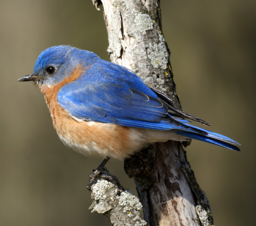

In [3]:
urls = search_images("bird", max_images=1)

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

img = Image.open(dest)
img.to_thumb(256,256)

Same thing, but for forests:

Searching for 'forest'


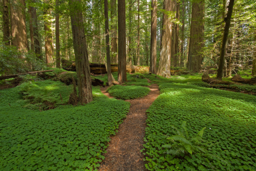

In [4]:
urls = search_images("forest", max_images=1)

dest = 'forest.jpg'
download_url(urls[0], dest, show_progress=False)

img = Image.open(dest)
img.to_thumb(256,256)

In [5]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for s in searches:
    # INFO: Images will be saved in a folder corresponding to their type
    dest = (path/s)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{s} photo', max_images=30))

    sleep(1)
    download_images(dest, urls=search_images(f'{s} sun photo', max_images=30))
    sleep(1)
    download_images(dest, urls=search_images(f'{s} shade photo', max_images=30))
    sleep(1)
    resize_images(path/s, max_size=400, dest=path/s)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


### Step 2: Training the model

In [6]:
# INFO: Makes sure that corrupted images won't affect the training by removing them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

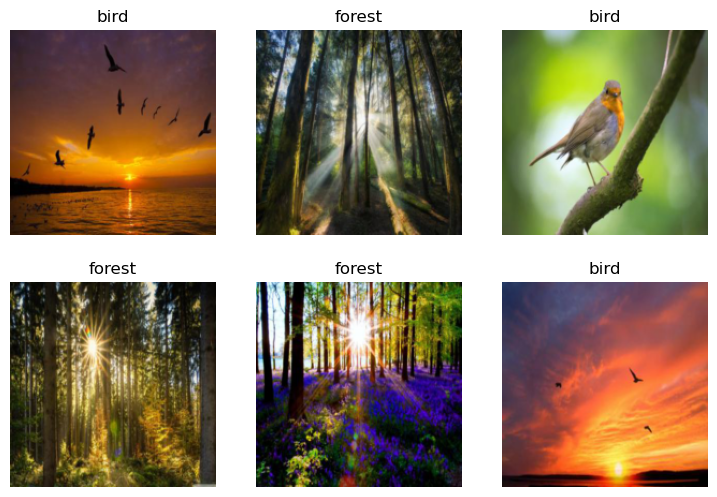

In [7]:
datablocks = DataBlock(
    # What the input and the output should be. For us the input is an image and
    # the output is a category (one of a number of possibilities).
    blocks=(ImageBlock, CategoryBlock),
    
    # How to get the data to use in the model.
    # `get_image_files` simply returns a list of paths.
    get_items=get_image_files,
    
    # Which splitter to use when creating the validation set. In this case
    # we randomly set aside 20% of the data.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    
    # Used to tell which label is associated to each image - for us, that means
    # either a bird or a forest.
    # `parent_label` is a helper fn that simply returns the parent folder name.
    get_y=parent_label,

    # How to transform data in the dataset. Here the only thing we done is
    # resizing the images so they are all 192x192. The method specifies how
    # this is done - in this case by squishing the entire img until it fits,
    # instead of cropping the center of it.
    item_tfms=[Resize(192, method='squish')]
)

# A `DataLoader` is an object that contains:
#  - training set: imgs used to train the model on
#  - validation set: imgs used to verify the accuracy of a model (NOT USED IN TRAINING!)
dls = datablocks.dataloaders(path, bs=32)

dls.show_batch(max_n=6)